In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

In [2]:
DATA_PATH = Path("../data")

## Functions

In [3]:
def standardize(series):
    return (series - series.mean()) / (series.max() - series.min())

## Item Response Models

In [4]:
df_wines = (
    pd.read_csv(DATA_PATH / "Wines2012.csv", sep=";")
    .assign(
        S=lambda x: standardize(x["score"]),
        J=lambda x:pd.factorize(x["judge"])[0], # x["judge"].astype("category").cat.codes,
        W=lambda x: pd.factorize(x["wine"])[0], #x["wine"].astype("category").cat.codes,
    )
    # .rename(
    #     columns={
    #         "wine.amer": "X",
    #         "judge.amer": "Z"
    #     }
    # )
)

In [5]:
df_wines["score"].mean()

14.2

In [6]:
df_wines.head()

,judge,flight,wine,score,wine.amer,judge.amer,S,J,W
0,Jean-M Cardebat,white,A1,10.0,1,0,-0.336,0,0
1,Jean-M Cardebat,white,B1,13.0,1,0,-0.096,0,1
2,Jean-M Cardebat,white,C1,14.0,0,0,-0.016,0,2
3,Jean-M Cardebat,white,D1,15.0,0,0,0.064,0,3
4,Jean-M Cardebat,white,E1,8.0,1,0,-0.496,0,4


## Models

In [24]:
wine_code, wine = pd.factorize(df_wines["wine"])
wine_amer = df_wines["wine.amer"].values
judge_code, judge = pd.factorize(df_wines["judge"])
judge_amer = df_wines["judge.amer"].values
score = standardize(df_wines["score"].values)

In [28]:
coords = {
    "wine": wine,
    "judge": judge,
    "wine_amer": np.unique(wine_amer),
    "judge_amer": np.unique(judge_amer)
}

### Model 0

In [29]:
with pm.Model(coords=coords) as wine_model_0:
    # Priors
    Q = pm.Normal("Q", mu=0, sigma=1, dims="wine")
    
    
    mu = pm.Deterministic("mu", var=Q[wine_code])
    sigma = pm.Exponential("sigma", lam=1)
    
    # Likelihood
    S = pm.Normal("S", mu=mu, sigma=sigma, observed=score)
    
    idata_0 = pm.sample_prior_predictive()
    idata_0.extend(pm.sample())

Sampling: [Q, S, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


(-5.0, 5.0)

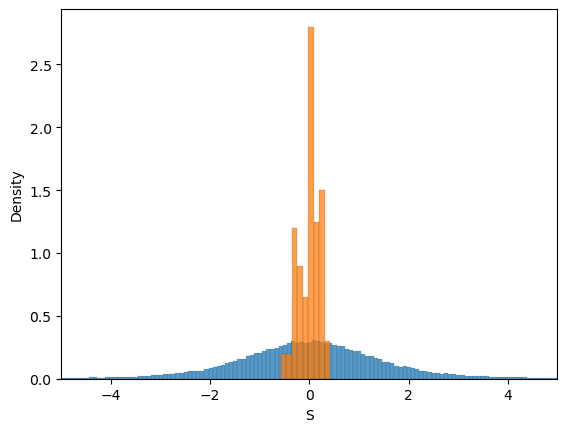

In [17]:
ax = sns.histplot(idata_0.prior_predictive["S"].values.flatten(), stat="density")
sns.histplot(df_wines["S"], ax=ax, stat="density")
ax.set_xlim(-5, 5)

In [32]:
az.summary(idata_0.posterior, var_names=["Q"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Q[A1],0.035,0.070,-0.092,0.171,0.001,0.001,8690.0,3037.0,1.0
Q[B1],0.064,0.073,-0.068,0.199,0.001,0.001,9202.0,2921.0,1.0
Q[C1],-0.028,0.073,-0.171,0.102,0.001,0.001,7973.0,2991.0,1.0
Q[D1],0.069,0.071,-0.069,0.202,0.001,0.001,8800.0,2724.0,1.0
Q[E1],0.019,0.069,-0.113,0.144,0.001,0.001,9812.0,3255.0,1.0
Q[F1],-0.002,0.070,-0.137,0.125,0.001,0.001,9589.0,2867.0,1.0
Q[G1],-0.024,0.070,-0.159,0.103,0.001,0.001,9708.0,3026.0,1.0
Q[H1],-0.051,0.070,-0.185,0.074,0.001,0.001,11073.0,3010.0,1.0
Q[I1],-0.035,0.070,-0.163,0.099,0.001,0.001,9422.0,2952.0,1.0
Q[J1],-0.038,0.070,-0.169,0.094,0.001,0.001,8636.0,2943.0,1.0


array([[<Axes: title={'center': 'Q'}>, <Axes: title={'center': 'Q'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

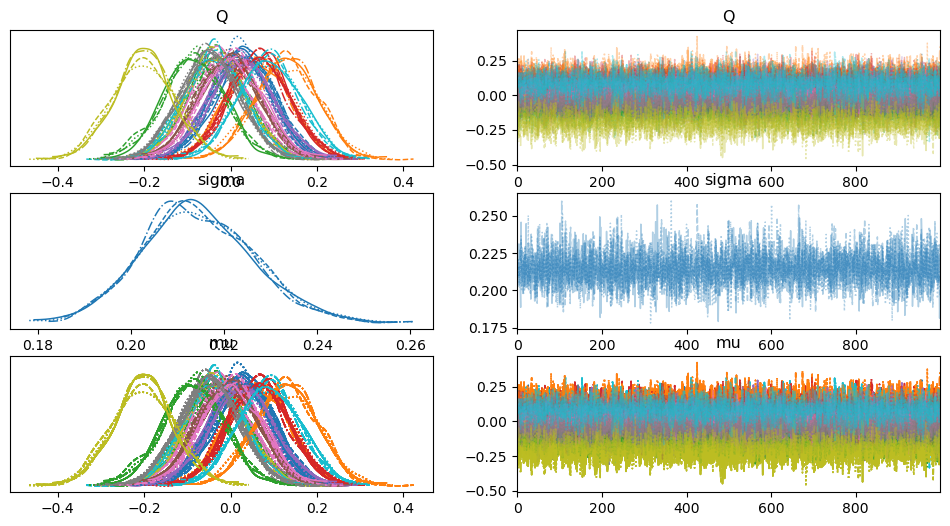

In [33]:
az.plot_trace(idata_0.posterior)

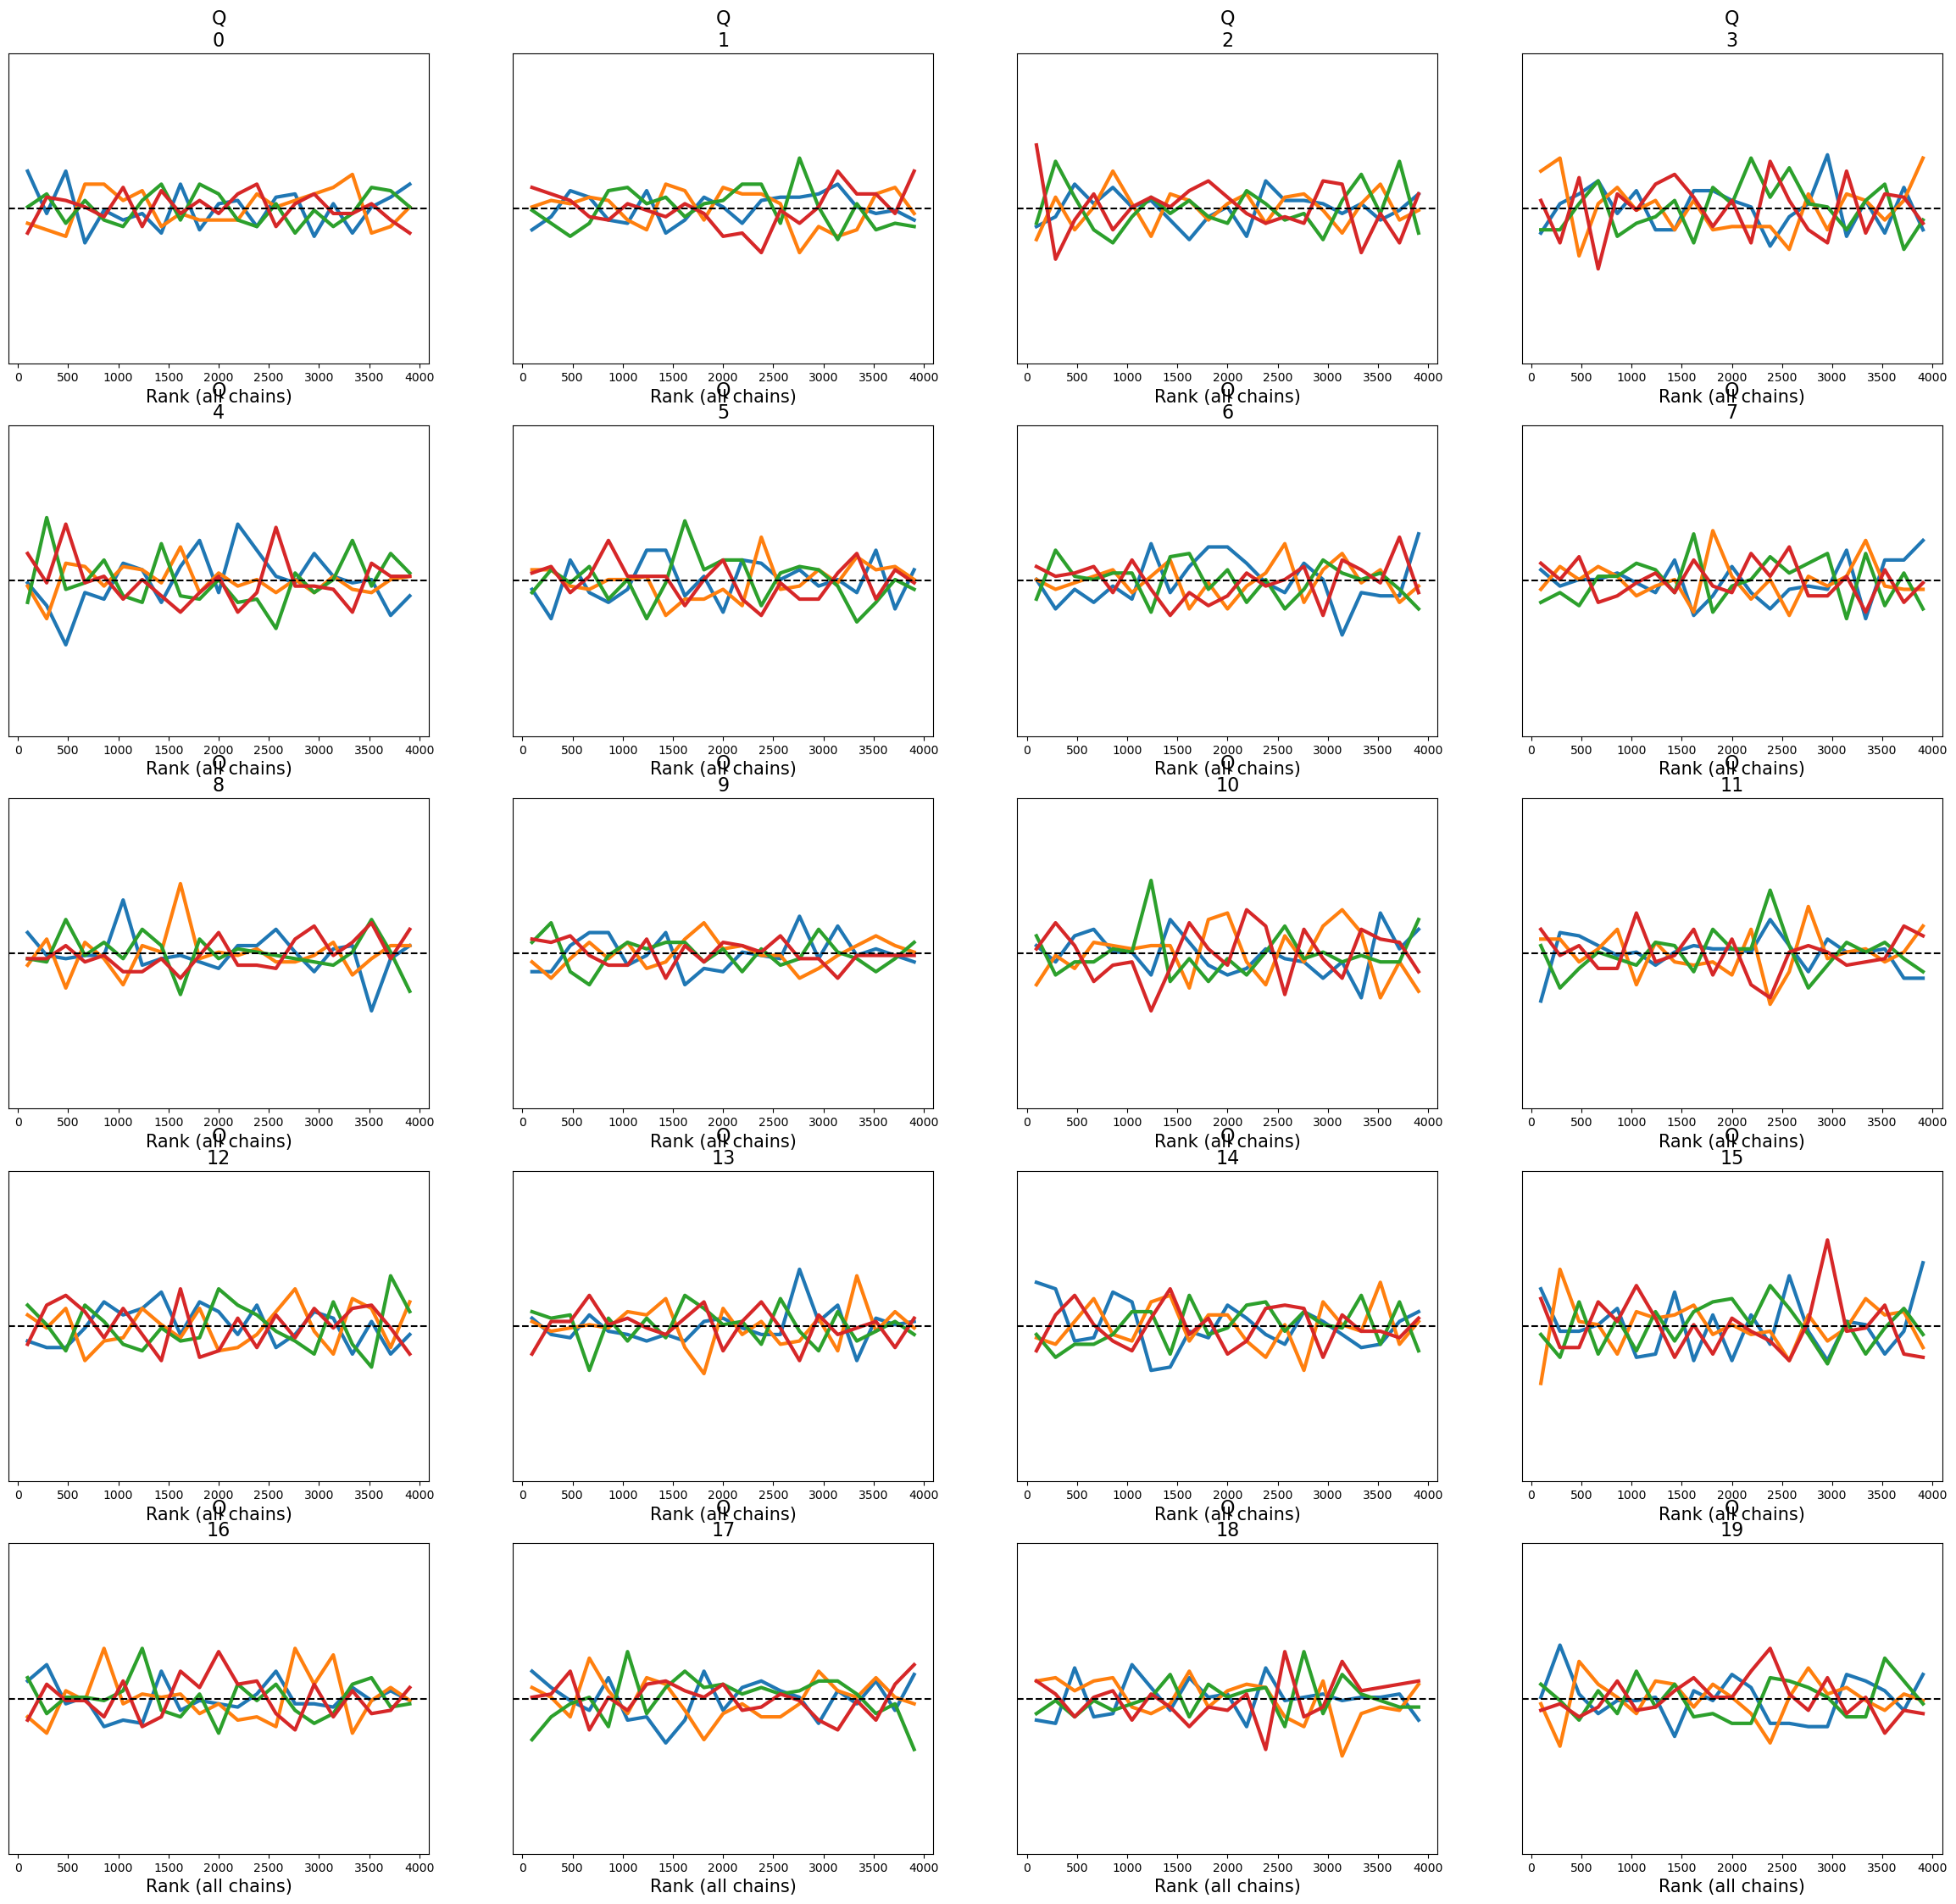

In [99]:
az.plot_rank(idata_0.posterior, var_names=["Q"], kind="vlines", vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3});

### Model with origin

In [100]:
with pm.Model(coords=coords) as wine_model_1:
    # Priors
    Q = pm.Normal("Q", mu=0, sigma=1, dims="wine")
    O = pm.Normal("O", mu=0, sigma=1, dims="wine_amer")
    
    
    mu = pm.Deterministic("mu", var=Q[df_wines["W"]] + O[df_wines["X"]])
    sigma = pm.Exponential("sigma", lam=1)
    
    # Likelihood
    S = pm.Normal("S", mu=mu, sigma=sigma, observed=df_wines["S"])
    
    idata_1 = pm.sample_prior_predictive()
    idata_1.extend(pm.sample())

Sampling: [O, Q, S, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q, O, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


In [101]:
az.summary(idata_1.posterior, var_names=["Q", "O"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Q[0],0.062,0.280,-0.516,0.558,0.014,0.010,398.0,609.0,1.01
Q[1],0.092,0.280,-0.457,0.593,0.014,0.010,405.0,574.0,1.01
Q[2],-0.059,0.348,-0.725,0.588,0.015,0.011,539.0,719.0,1.01
Q[3],0.040,0.348,-0.617,0.696,0.015,0.011,531.0,699.0,1.01
Q[4],0.048,0.279,-0.478,0.573,0.014,0.010,402.0,564.0,1.01
Q[5],0.025,0.280,-0.529,0.511,0.014,0.010,406.0,576.0,1.01
Q[6],0.004,0.280,-0.533,0.523,0.014,0.010,403.0,564.0,1.01
Q[7],-0.079,0.345,-0.740,0.557,0.015,0.011,523.0,675.0,1.01
Q[8],-0.006,0.279,-0.550,0.494,0.014,0.010,407.0,495.0,1.01
Q[9],-0.066,0.348,-0.706,0.597,0.015,0.011,529.0,705.0,1.01


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

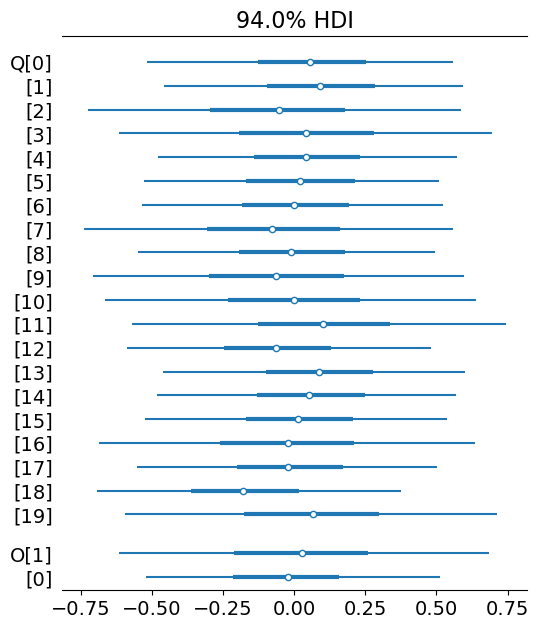

In [105]:
az.plot_forest(idata_1.posterior, var_names=["Q", "O"], combined=True, )

In [18]:
normal_dist = pm.Normal.dist(mu=0, sigma=1)

In [19]:
normal_dist

normal_rv{0, (0, 0), floatX, False}.out

<Axes: ylabel='Count'>

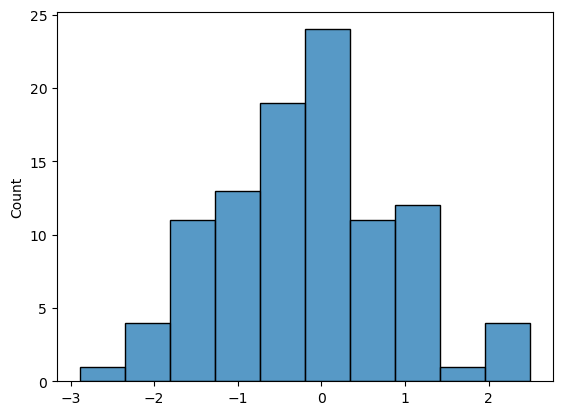

In [22]:
sns.histplot(pm.draw(normal_dist, draws=100))

In [73]:
from scipy import stats
import numpy as np

In [84]:
draws = np.random.choice(np.arange(1, 7, 1), replace=True, size=(1000, 2))
drawswithone = [draw for draw in draws if any(draw == 1)]
drawsallone = [draw for draw in draws if all(draw == 1)]

In [85]:
len(drawsallone) / len(drawswithone)

0.0949367088607595